In [1]:
import datetime
import pytz
import copy
import glob
import os
import math 
import enum

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mplfinance as mpf
from stock_indicators import indicators
from stock_indicators.indicators.common.quote import Quote

# Загрузка данных

In [171]:
path = "data\\2024-GDM4"
#path = "data\\2024-GDU4"

all_files = glob.glob(os.path.join(path, "*.csv"))
ticker_data = pd.concat((pd.read_csv(f, 
                            delimiter=";",
                            usecols=[1,2,3,4,5,6], 
                            names=['UTC', 'open', 'close','high','low','volume'],
                            dtype = {'UTC': 'str', 
                                      'open': 'float', 
                                      'close': 'float', 
                                      'high': 'float',
                                      'low': 'float',
                                      'volume': 'int'},
                            parse_dates=['UTC']
                           ) 
                for f in all_files), ignore_index=True)
ticker_data.index = pd.DatetimeIndex(ticker_data['UTC'])
ticker_data.drop(['UTC'], axis=1, inplace=True)

In [172]:
len(ticker_data)

75773

In [173]:
ticker_data

,open,close,high,low,volume
UTC,,,,,
2024-01-03 06:05:00+00:00,2124.7,2124.5,2125.0,2124.5,11
2024-01-03 06:13:00+00:00,2123.5,2123.5,2123.5,2123.5,1
2024-01-03 06:17:00+00:00,2122.7,2122.7,2122.7,2122.7,1
2024-01-03 06:19:00+00:00,2122.1,2122.1,2122.1,2122.1,1
2024-01-03 06:20:00+00:00,2122.1,2122.0,2122.1,2122.0,8
...,...,...,...,...,...
2024-06-21 10:47:00+00:00,2333.0,2333.0,2333.0,2333.0,11
2024-06-21 10:48:00+00:00,2333.0,2333.0,2333.0,2333.0,154
2024-06-21 10:49:00+00:00,2333.1,2333.1,2333.1,2333.1,3


# Описание стратегии

In [174]:
class StrategySignal(enum.Enum):
    NO = 1
    BULL = 2
    BEAR = 3

In [175]:
class StrategyCommand(enum.Enum):
    HOLD = 1
    BUY = 2
    SELL = 3
    CLOSE = 4
    STOP_LOSS = 5

In [176]:
class Strategy:
    
    # конфигурация
    frame_size = 22
    fractal_enabled = True
    fractal_size = 4
    
    def __init__(self):
        
        return

    # Расчет индикаторов
    def calc_indicators(self, data ):
        quotes = [Quote(d,o,h,l,c,v) for d,o,h,l,c,v in zip(data.index, data['open'], data['high'], data['low'], data['close'], data['volume'])]
        alligator = indicators.get_alligator(quotes)
        fractal = indicators.get_fractal(quotes, self.fractal_size)
        result = data.copy()
        result["jaw"] = [ a.jaw for a in alligator]
        result["teeth"] = [ a.teeth for a in alligator]
        result["lips"] = [ a.lips for a in alligator]
        result["fractal_bear"] = [ f.fractal_bear if f.fractal_bear != None else np.nan for f in fractal]
        result["fractal_bull"] = [ f.fractal_bull if f.fractal_bull != None else np.nan for f in fractal]
        return result

    # helper
    def get_params(self,data):
        
        index = data.tail(1).index[0]
        fractal_index = data.tail(self.fractal_size).index[0]
        return (
                index,
                data.at[index, 'open'], 
                data.at[index, 'close'],
                data.at[index, 'high'],
                data.at[index, 'low'],
                data.at[index, 'volume'],

                data.at[index, 'jaw'],
                data.at[index, 'teeth'],
                data.at[index, 'lips'],

                data.at[fractal_index, 'fractal_bear'],
                data.at[fractal_index, 'fractal_bull']
           )
    
    # обработка шага стратегии
    def next(self, position, stop_loss, data):

        
        #инициализация локальных переменных
        indicators = self.calc_indicators(data)
        time, open_, close, high, low, volume, jaw, teeth, lips, fractal_bear, fractal_bull = self.get_params(indicators)
        last_row = indicators.tail(1)
        last_row.loc[ last_row.index[0], 'fractal_bull'] = fractal_bull 
        last_row.loc[ last_row.index[0], 'fractal_bear'] = fractal_bear

        # проверка полноты данных
        if ( len(data.index) < self.frame_size):
            return StrategyCommand.HOLD, stop_loss, last_row
        
        # прерываем исполнение, если недостаточно данных
        if ( math.isnan(jaw) or 
             math.isnan(teeth) or 
             math.isnan(lips) or
             volume == 0 or 
             len(indicators.index) < self.frame_size):
            return StrategyCommand.HOLD, stop_loss, last_row

        #Определяем состояние индикатора аллигатора
        if   (lips > teeth and lips > jaw and close > lips and lips >= low): 
            alligator_signal = StrategySignal.BULL
        elif (lips < teeth and lips < jaw and close < lips and lips <= high):
            alligator_signal = StrategySignal.BEAR
        else:
            alligator_signal = StrategySignal.NO
     
        # ищем точку входа
        if ( position == 0 ):

            #лонгуем
            if   (alligator_signal == StrategySignal.BULL): 
                stop_loss = lips
                return StrategyCommand.BUY, stop_loss, last_row
                    
            #шортим
            elif (alligator_signal == StrategySignal.BEAR):
                stop_loss = lips
                return StrategyCommand.SELL, stop_loss, last_row
        
        #Проверяем выход из лонга    
        elif( position > 0 ):
            
            # выход по условиям
            if( 
                close < lips 
                or (not math.isnan(fractal_bear) and fractal_enabled) 
            ):
                return StrategyCommand.CLOSE, stop_loss, last_row
            else:
                stop_loss = max(stop_loss, lips)

        #проверяем выход из шорта
        elif ( position < 0 ):
        
            # выход по условиям
            if( 
                close > lips 
                or (not math.isnan(fractal_bull) and fractal_enabled) 
            ):
                return StrategyCommand.CLOSE, stop_loss, last_row
            else:
                stop_loss = min( stop_loss, lips)
        
        return StrategyCommand.HOLD, stop_loss, last_row 

# Моделирование торговли

In [177]:
processig_data = ticker_data

#2024-GDM4
processig_data = ticker_data['2024-03-01 00:00:00':'2024-06-01 00:00:00']

#2024-GDU4
#processig_data = ticker_data['2024-06-01 00:00:00':'2024-09-01 00:00:00']
#processig_data = ticker_data['2024-06-21 00:00:00':'2024-06-26 00:00:00']

In [178]:
len(processig_data)

53862

In [179]:
points = 0      # количесво выйграных пунктов цены
position = 0    # количество преобретенного инструмента
enter_price = 0
stop_loss = 0
bull_deals = 0
bear_deals = 0
rows = []
points_log = []
bear_stop_loss = []
bull_stop_loss = []

# подготавливаем данные по дням
days_data = [group[1] for group in processig_data.groupby(processig_data.index.date)]

# запускаем цикл по дням
strategy = Strategy()
for day_data in days_data:

    # эмитация торговли внутри дня
    for index in day_data.index:
        target_loc = day_data.index.get_loc(index)
        start_loc = max(0, target_loc - strategy.frame_size)
        curient_frame = day_data.iloc[start_loc:target_loc + 1]
        low   = curient_frame['low'  ].iloc[-1]
        high  = curient_frame['high' ].iloc[-1]
        close = curient_frame['close'].iloc[-1]

        # выход по лимиту
        if(   position > 0 and stop_loss > low ):
            strategy.status = StrategyStatus.SEARCH
            position = 0 
            points += stop_loss - enter_price
            bull_deals += 1
        elif( position < 0 and stop_loss < high ):
            strategy.status = StrategyStatus.SEARCH
            position = 0 
            points += enter_price - stop_loss
            bear_deals += 1

        # получаем команду от стратегии
        command, stop_loss, row = strategy.next(position, stop_loss, curient_frame)

        # Если нужно, выполняем закрытие позиций
        if(   command == StrategyCommand.BUY ):
            strategy.status = StrategyStatus.BULL
            enter_price = close
            position = 1
        elif( command == StrategyCommand.SELL):
            strategy.status = StrategyStatus.BEAR
            enter_price = close
            position = -1
        elif( command == StrategyCommand.CLOSE and position > 0 ):
            strategy.status = StrategyStatus.SEARCH
            points += close - enter_price
            position = 0 
            bull_deals += 1
        elif( command == StrategyCommand.CLOSE and position < 0 ):
            strategy.status = StrategyStatus.SEARCH
            points += enter_price - close
            position = 0 
            bear_deals += 1

        # заносим промежуточные параметры в массивы
        rows += [row]
        points_log += [points]
        bull_stop_loss += [ stop_loss if position > 0 else np.nan ]
        bear_stop_loss += [ stop_loss if position < 0 else np.nan ]

    #выводим результаты на конец очереднго дня
    print(day_data.index[0].date, "bars:", len(day_data.index), "points:", points, "bull_deals:", bull_deals, "bear_deals:", bear_deals)

processed_data = pd.concat(rows)
processed_data['points'] = points_log
processed_data['bull_stop_loss'] = bull_stop_loss
processed_data['bear_stop_loss'] = bear_stop_loss

<bound method Timestamp.date of Timestamp('2024-03-01 06:00:00+0000', tz='UTC')> bars: 605 points: 5.299745891488783 bull_deals: 11 bear_deals: 4
<bound method Timestamp.date of Timestamp('2024-03-04 05:59:00+0000', tz='UTC')> bars: 769 points: -0.1617953529935221 bull_deals: 29 bear_deals: 18
<bound method Timestamp.date of Timestamp('2024-03-05 05:59:00+0000', tz='UTC')> bars: 700 points: 5.3814986681795745 bull_deals: 37 bear_deals: 29
<bound method Timestamp.date of Timestamp('2024-03-06 05:59:00+0000', tz='UTC')> bars: 709 points: 12.21407496706206 bull_deals: 50 bear_deals: 33
<bound method Timestamp.date of Timestamp('2024-03-07 05:59:00+0000', tz='UTC')> bars: 708 points: 19.307633965415334 bull_deals: 65 bear_deals: 37
<bound method Timestamp.date of Timestamp('2024-03-11 05:59:00+0000', tz='UTC')> bars: 722 points: 15.944965720292657 bull_deals: 77 bear_deals: 50
<bound method Timestamp.date of Timestamp('2024-03-12 05:59:00+0000', tz='UTC')> bars: 749 points: 17.705494438627

C:\Users\ЕА\AppData\Local\Temp\ipykernel_7020\1027629623.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = pd.concat(rows)


In [180]:
processed_data.head(50+810).tail(50)

,open,close,high,low,volume,jaw,teeth,lips,fractal_bear,fractal_bull,points,bull_stop_loss,bear_stop_loss
UTC,,,,,,,,,,,,,
2024-03-04 09:57:00+00:00,2121.3,2121.3,2121.3,2121.3,3,2121.214247,2121.245145,2121.277127,NaN,NaN,4.422417,2121.277127,NaN
2024-03-04 09:58:00+00:00,2121.3,2121.3,2121.3,2121.2,37,2121.234456,2121.257551,2121.282616,NaN,NaN,4.399544,2121.282616,NaN
2024-03-04 09:59:00+00:00,2121.3,2121.3,2121.3,2121.3,2,2121.254119,2121.269639,2121.287149,NaN,NaN,4.399544,2121.287149,NaN
2024-03-04 10:00:00+00:00,2121.3,2121.3,2121.3,2121.3,13,2121.256827,2121.274462,2121.289789,NaN,NaN,4.399544,2121.289789,NaN
2024-03-04 10:01:00+00:00,2121.3,2121.3,2121.3,2121.3,5,2121.257123,2121.275599,2121.281339,NaN,NaN,4.399544,2121.289789,NaN
2024-03-04 10:02:00+00:00,2121.3,2121.3,2121.3,2121.3,2,2121.267228,2121.281527,2121.285634,NaN,NaN,4.399544,2121.289789,NaN
2024-03-04 10:03:00+00:00,2121.3,2121.3,2121.3,2121.3,1,2121.280337,2121.282724,2121.289492,NaN,NaN,4.399544,2121.289789,NaN
2024-03-04 10:04:00+00:00,2121.3,2121.3,2121.3,2121.3,3,2121.280337,2121.283856,2121.291383,NaN,NaN,4.399544,2121.291383,NaN
2024-03-04 10:05:00+00:00,2121.3,2121.3,2121.3,2121.3,68,2121.280337,2121.284846,2121.292895,NaN,NaN,4.399544,2121.292895,NaN


# Оценка результатов тестирования

In [181]:
leverage = 8

In [182]:
mean_price = np.mean(processed_data['close'])
print("Result: ", points, "pt. ", points/mean_price*leverage*100, "%"  ) 
print("Max: ", max(processed_data['points']), "pt. ", max(processed_data['points'])/mean_price*leverage*100, "%")
print("Min: ", min(processed_data['points']), "pt. ", min(processed_data['points'])/mean_price*leverage*100, "%")
print("Deals: ", bull_deals + bear_deals)
print("Bull deals: ", bull_deals)
print("Bear deals: ", bear_deals)

Result:  555.0649417421664 pt.  191.62723530144493 %
Max:  556.5010488952116 pt.  192.12302817654694 %
Min:  -0.5422436963235668 pt.  -0.1872009067263125 %
Deals:  3452
Bull deals:  1742
Bear deals:  1710


In [183]:
#расчитываем распределение проседания
local_max = processed_data.iloc[0]
local_min = processed_data.iloc[0]
losses = []
for i in processed_data.index:
    row = processed_data.loc[i]
    if local_max['points'] < row['points']:
        if local_max['points'] > local_min['points']:
            losses += [{ "value": (local_max['points'] - local_min['points']), "start": local_max.name, "end": local_min.name}]
        local_max = row
        local_min = row
            
    elif local_min['points'] > row['points']:
        local_min = row

max_loss_value = max([l["value"] for l in losses ])
for l in losses:
    if l["value"] == max_loss_value:
        print("Max loss:", max_loss_value, " start:", l["start"], " end:", l["end"], " days:", (l["end"] - l["start"]).days)
        break
print("3 sigma: ", np.var([l["value"] for l in losses ])*3)

Max loss: 16.289275786058624  start: 2024-03-18 16:18:00+00:00  end: 2024-03-20 18:52:00+00:00  days: 2
3 sigma:  23.81444913090121


# Визуализация

In [184]:
view_data = processed_data.loc['2024-05-06 6:00:00':'2024-05-06 10:00:00']
view_data

,open,close,high,low,volume,jaw,teeth,lips,fractal_bear,fractal_bull,points,bull_stop_loss,bear_stop_loss
UTC,,,,,,,,,,,,,
2024-05-06 06:00:00+00:00,2326.1,2327.8,2328.5,2326.1,1813,NaN,NaN,NaN,NaN,NaN,396.358040,2317.410514,NaN
2024-05-06 06:01:00+00:00,2327.8,2327.6,2327.9,2327.5,433,NaN,NaN,NaN,NaN,NaN,396.358040,2317.410514,NaN
2024-05-06 06:02:00+00:00,2327.7,2327.7,2327.8,2327.5,355,NaN,NaN,NaN,NaN,NaN,396.358040,2317.410514,NaN
2024-05-06 06:03:00+00:00,2327.6,2327.1,2327.7,2327.1,280,NaN,NaN,NaN,NaN,NaN,396.358040,2317.410514,NaN
2024-05-06 06:04:00+00:00,2327.1,2327.3,2327.4,2327.0,343,NaN,NaN,NaN,NaN,NaN,396.358040,2317.410514,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06 09:56:00+00:00,2334.4,2334.6,2334.9,2334.4,259,2331.140737,2332.191407,2332.973372,NaN,NaN,405.877774,2332.973372,NaN
2024-05-06 09:57:00+00:00,2334.5,2334.9,2334.9,2334.5,168,2331.339736,2332.324637,2333.077291,NaN,NaN,405.877774,2333.077291,NaN
2024-05-06 09:58:00+00:00,2334.7,2334.3,2335.0,2334.2,242,2331.556645,2332.447585,2333.270566,NaN,NaN,405.877774,2333.270566,NaN


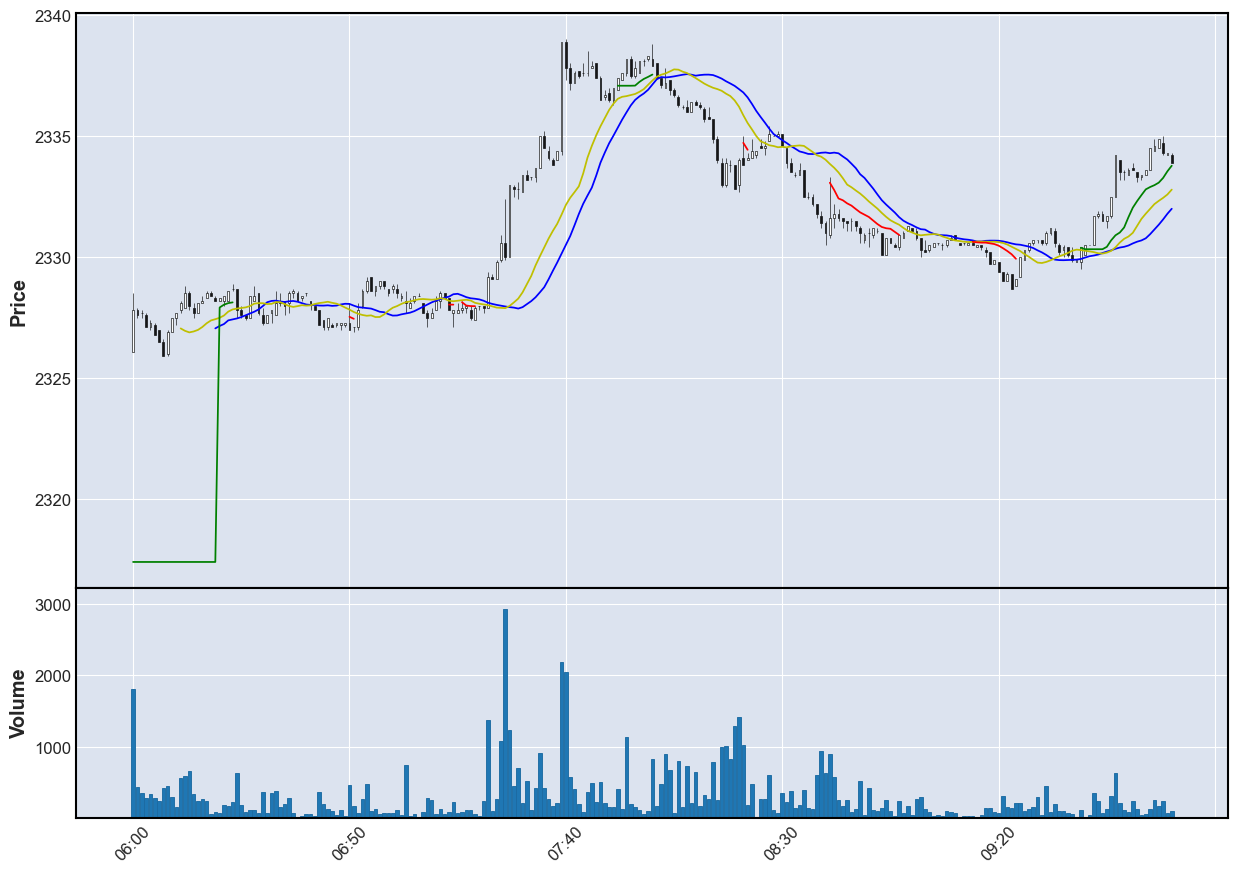

In [185]:

apds = [ mpf.make_addplot(view_data["jaw"],   color="b"),
         mpf.make_addplot(view_data["teeth"], color="y"),
         #mpf.make_addplot(view_data["lips"],  color="orange"),
         #mpf.make_addplot(view_data["fractal_bull"],   type='scatter', marker='^'),
         #mpf.make_addplot(view_data["fractal_bear"],   type='scatter', marker='v'),
         mpf.make_addplot(view_data["bull_stop_loss"], color="g"),
         mpf.make_addplot(view_data["bear_stop_loss"], color="r")
       ]
mpf.plot(view_data, addplot=apds, type='candle', volume=True,figscale=2)

(array([61., 36., 19., 12., 17., 13.,  6.,  3.,  3.,  3.,  2.,  0.,  4.,
         0.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([1.23825877e-03, 7.09413803e-01, 1.41758935e+00, 2.12576489e+00,
        2.83394044e+00, 3.54211598e+00, 4.25029153e+00, 4.95846707e+00,
        5.66664262e+00, 6.37481816e+00, 7.08299371e+00, 7.79116925e+00,
        8.49934479e+00, 9.20752034e+00, 9.91569588e+00, 1.06238714e+01,
        1.13320470e+01, 1.20402225e+01, 1.27483981e+01, 1.34565736e+01,
        1.41647492e+01, 1.48729247e+01, 1.55811002e+01, 1.62892758e+01]),
 <BarContainer object of 23 artists>)

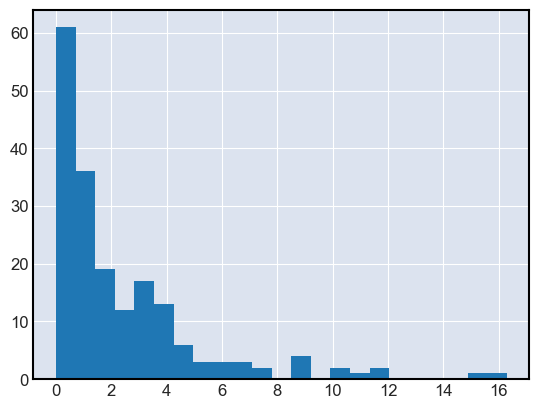

In [186]:
plt.hist([l["value"] for l in losses ], int(np.var([l["value"] for l in losses ])*3))